In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
df = pd.read_csv('/content/Housing.csv')

# basic info
print("Dataset Info:")
print(df.info())
print("\nexample rows")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

example rows
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2    

In [108]:

# missing values
df = df.fillna(df.median(numeric_only=True))
df = df.dropna()  # remove missing vals

#  fix outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['area', 'price']:
    df = remove_outliers(df, col)

In [109]:
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
17,8960000,8500,3,2,4,yes,no,no,no,yes,2,no,furnished
18,8890000,4600,3,2,2,yes,yes,no,no,yes,2,no,furnished
19,8855000,6420,3,2,2,yes,no,no,no,yes,1,yes,semi-furnished
20,8750000,4320,3,1,2,yes,no,yes,yes,no,2,no,semi-furnished
21,8680000,7155,3,2,1,yes,yes,yes,no,yes,2,no,unfurnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [110]:

# new cols for better metrics

# property varying cols for total rooms , space and bathroom to room ratio
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df['space_per_room'] = df['area'] / (df['bedrooms'] + df['bathrooms'] + 1)
df['bathroom_ratio'] = df['bathrooms'] / (df['bedrooms'] + 1)

# this has shown to be one of the most important col as we have turned it into a mix that includes all amenities with scores
df['amenity_score'] = (df['mainroad'] == 'yes').astype(int) + \
                     (df['guestroom'] == 'yes').astype(int) + \
                     (df['airconditioning'] == 'yes').astype(int) + \
                     (df['prefarea'] == 'yes').astype(int)

# no of floors and storie ratio with parking +1 so it doesnt become infinity
df['floor_area_ratio'] = df['area'] / (df['stories'] + 1)
df['parking_per_room'] = df['parking'] / (df['bedrooms'] + 1)

In [111]:
furnished_col = ['furnishingstatus']
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
              'airconditioning', 'prefarea']

In [112]:
print("binary vals")
for col in binary_cols:
    print(f"{col}: {df[col].unique()}")

print("furnished col vals")
for col in furnished_col:
    print(f"{col}: {df[col].unique()}")

binary vals
mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['no' 'yes']
furnished col vals
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


In [113]:
#copying data for linear regression and rf and dt to test with and without numerical cols
cop_df = df
test_df = df


In [11]:
#  categorical variables mapping to numerical for better multi linear regression

for col in binary_cols:
    cop_df[col] = df[col].map({'yes': 1, 'no': 0})

furnished_col = ['furnishingstatus']
for col in furnished_col:
    cop_df[col] = df[col].map({'furnished': 1, 'semi-furnished':0.5 ,'unfurnished': 0})

In [12]:
cop_df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,total_rooms,space_per_room,bathroom_ratio,amenity_score,floor_area_ratio,parking_per_room
17,8960000,8500,3,2,4,1,0,0,0,1,2,0,1.0,5,1416.666667,0.500000,2,1700.000000,0.500000
18,8890000,4600,3,2,2,1,1,0,0,1,2,0,1.0,5,766.666667,0.500000,3,1533.333333,0.500000
19,8855000,6420,3,2,2,1,0,0,0,1,1,1,0.5,5,1070.000000,0.500000,3,2140.000000,0.250000
20,8750000,4320,3,1,2,1,0,1,1,0,2,0,0.5,4,864.000000,0.250000,1,1440.000000,0.500000
21,8680000,7155,3,2,1,1,1,1,0,1,2,0,0.0,5,1192.500000,0.500000,3,3577.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0.0,3,750.000000,0.333333,1,1500.000000,0.666667
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,0.5,4,480.000000,0.250000,0,1200.000000,0.000000
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0.0,3,905.000000,0.333333,1,1810.000000,0.000000
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1.0,4,582.000000,0.250000,0,1455.000000,0.000000


In [15]:
#using data with both numerical and string for decision tree and random forest as it seemed to be better
X_r = test_df.drop('price', axis=1)
y_r = test_df['price']

X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

In [13]:

X = cop_df.drop('price', axis=1)
y = cop_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling
scaler = StandardScaler()
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking',
                 'total_rooms', 'space_per_room', 'bathroom_ratio',
                 'amenity_score', 'floor_area_ratio', 'parking_per_room']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:
X_train[numerical_cols]

,area,bedrooms,bathrooms,stories,parking,total_rooms,space_per_room,bathroom_ratio,amenity_score,floor_area_ratio,parking_per_room
432,0.634419,0.081463,-0.545258,-0.907611,-0.778742,-0.191301,0.634327,-0.663215,0.477450,1.177392,-0.770881
357,1.119467,1.430484,-0.545258,0.281474,0.419768,0.811214,0.483869,-1.127092,-1.636605,0.406613,0.157186
246,-0.781700,0.081463,-0.545258,-0.907611,-0.778742,-0.191301,-0.706590,-0.663215,0.477450,-0.182177,-0.770881
171,2.981050,0.081463,-0.545258,-0.907611,0.419768,-0.191301,2.856342,-0.663215,0.477450,3.430316,0.389203
327,0.868580,0.081463,-0.545258,0.281474,0.419768,-0.191301,0.856053,-0.663215,-0.579578,0.246034,0.389203
...,...,...,...,...,...,...,...,...,...,...,...
92,-0.068065,0.081463,1.625288,2.659646,-0.778742,0.811214,-0.453189,1.656170,1.534477,-1.038598,-0.770881
128,0.322204,0.081463,-0.545258,1.470560,0.419768,-0.191301,0.338691,-0.663215,1.534477,-0.594330,0.389203
296,-0.179571,0.081463,1.625288,0.281474,0.419768,0.811214,-0.541175,1.656170,0.477450,-0.424830,0.389203
462,-1.539937,0.081463,-0.545258,0.281474,-0.778742,-0.191301,-1.424561,-0.663215,-1.636605,-1.295525,-0.770881


In [22]:
from sklearn.model_selection import GridSearchCV

In [99]:
# linear regression model with numerical fit data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

# decision tree model with fit parameters and grisearch for better fit
dt_params = {
    'max_depth': [5, 10, 15, 20, 30, 50],
    'min_samples_split': [5, 10, 15, 20, 30, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [10, 15, 20, 'sqrt', 'log2', None]
}
dt_model = DecisionTreeRegressor(random_state=42)
dt_model= GridSearchCV(estimator=dt_model, param_grid=dt_params, cv=7, scoring='r2', verbose=1, n_jobs=-1)
dt_model.fit(X_r_train, y_r_train)
dt_pred = dt_model.predict(X_r_test)
dt_mse = mean_squared_error(y_r_test, dt_pred)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_r_test, dt_pred)

# random forest
rf_model = RandomForestRegressor(n_estimators=42, random_state=42)
rf_model.fit(X_r_train, y_r_train)
rf_pred = rf_model.predict(X_r_test)
rf_mse = mean_squared_error(y_r_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_r_test, rf_pred)

Fitting 7 folds for each of 1080 candidates, totalling 7560 fits


In [100]:
# Results
# it is found that the best model seem to be random forest with 42 estimators lower or higher than that seem to reduce the score
# the decision tree als give the best result at grid search cv = 7
print("Linear Regression Results:")
print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")
print(f"R2 Score: {lr_r2:.2f}\n")

print("Decision Tree Results:")
print(f"MSE: {dt_mse:.2f}")
print(f"RMSE: {dt_rmse:.2f}")
print(f"R2 Score: {dt_r2:.2f}\n")

print("Random Forest Results:")
print(f"MSE: {rf_mse:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R2 Score: {rf_r2:.2f}")

Linear Regression Results:
MSE: 938291175486.79
RMSE: 968654.31
R2 Score: 0.71

Decision Tree Results:
MSE: 1074002763184.11
RMSE: 1036341.05
R2 Score: 0.67

Random Forest Results:
MSE: 866860067318.34
RMSE: 931053.20
R2 Score: 0.74


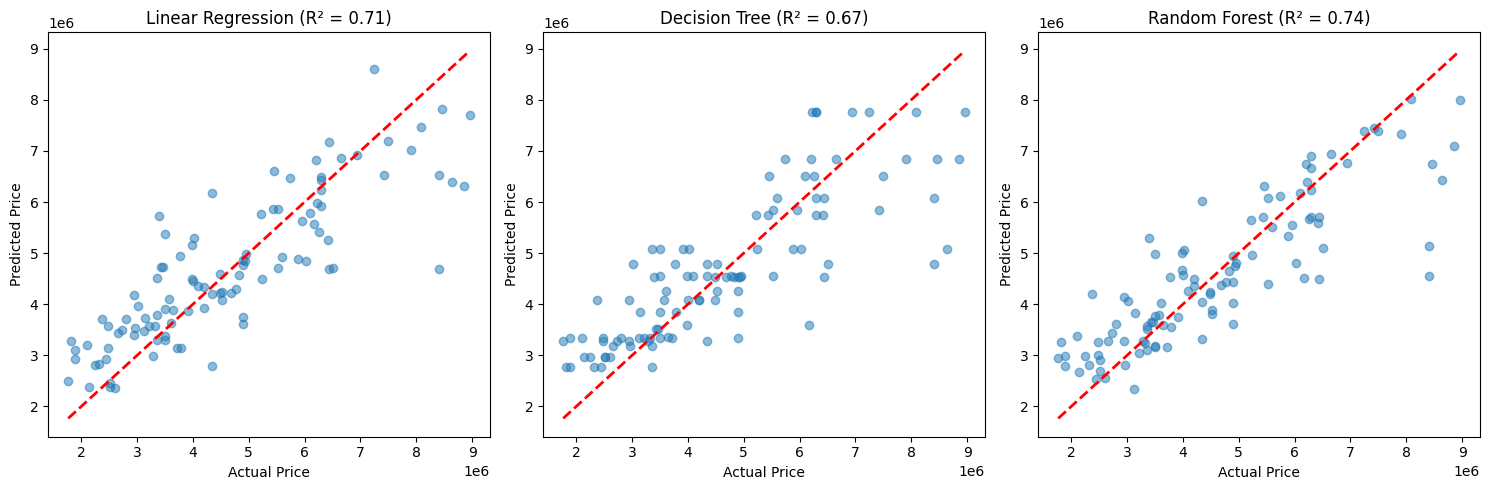

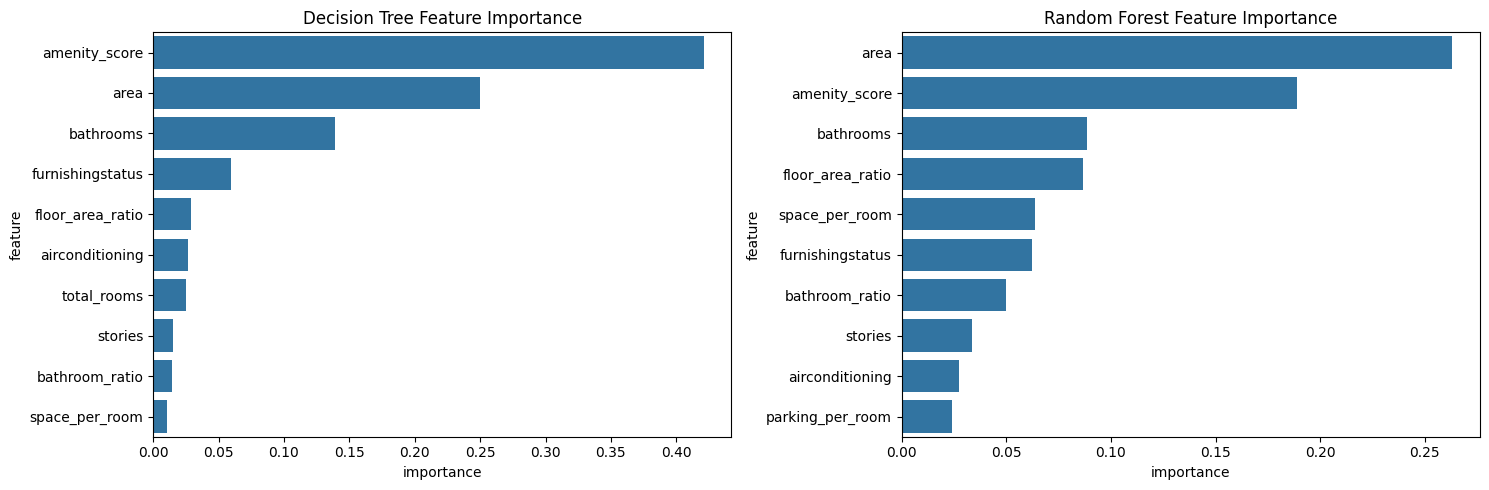

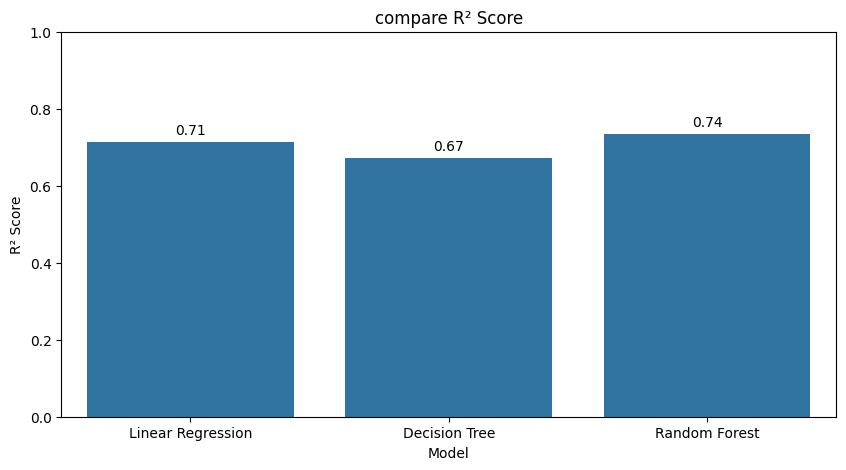

In [114]:
plt.figure(figsize=(15, 5))

# lr
plt.subplot(1, 3, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Linear Regression (R² = {lr_r2:.2f})')

# dt
plt.subplot(1, 3, 2)
plt.scatter(y_r_test, dt_pred, alpha=0.5)
plt.plot([y_r_test.min(), y_r_test.max()], [y_r_test.min(), y_r_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Decision Tree (R² = {dt_r2:.2f})')

# rf
plt.subplot(1, 3, 3)
plt.scatter(y_r_test, rf_pred, alpha=0.5)
plt.plot([y_r_test.min(), y_r_test.max()], [y_r_test.min(), y_r_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Random Forest (R² = {rf_r2:.2f})')

plt.tight_layout()
plt.show()


# feature importance for dt and rf
plt.figure(figsize=(15, 5))

# dt
plt.subplot(1, 2, 1)
dt_importance = pd.DataFrame({'feature': X_train.columns, 'importance': dt_best.feature_importances_})
dt_importance = dt_importance.sort_values('importance', ascending=False).head(10)
sns.barplot(x='importance', y='feature', data=dt_importance)
plt.title('Decision Tree Feature Importance')

# rf
plt.subplot(1, 2, 2)
rf_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf_model.feature_importances_})
rf_importance = rf_importance.sort_values('importance', ascending=False).head(10)
sns.barplot(x='importance', y='feature', data=rf_importance)
plt.title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()

# bar plot
metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'R² Score': [lr_r2, dt_r2, rf_r2],
    'RMSE': [lr_rmse, dt_rmse, rf_rmse]
})

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='R² Score', data=metrics)
plt.title('compare R² Score')
plt.ylim(0, 1)
for i, v in enumerate(metrics['R² Score']):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
plt.show()

# we see amenity score col created seem to have major impact other than are , also the cols we created seem to have much higher impact
# than normal columns we setup earlier